In [1]:
import trimesh

import torch
from torch.utils.data import Dataset
from tqdm import tqdm

import sys
sys.path.append('/home/s94zalek/shape_matching')

import my_code.datasets.template_dataset as template_dataset
import datasets_code.shape_dataset as shape_dataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [91]:
dataset_faust_single = shape_dataset.SingleFaustDataset(
        data_root='data/FAUST_original',
        phase='train',
        return_faces=True,
        return_evecs=True, num_evecs=32,
        return_corr=True, return_dist=False
    )
    
dataset_template = template_dataset.TemplateDataset(
    base_dataset=dataset_faust_single,
    num_evecs=32
)

Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 15.05it/s]


In [ ]:
scene = trimesh.Scene()

In [ ]:
import numpy as np

scene.geometry.clear()

data_0 = dataset_template[23]

mesh_first = trimesh.Trimesh(vertices=data_0['first']['verts'], faces=data_0['first']['faces'])
cmap = trimesh.visual.color.interpolate(mesh_first.vertices[:, 1], 'jet')
mesh_first.visual.vertex_colors = cmap


mesh_second = trimesh.Trimesh(vertices=data_0['second']['verts'] + np.array([1, 0, 0]), faces=data_0['second']['faces'],
                              vertex_colors=cmap[data_0['second']['corr']])

scene.add_geometry(mesh_first)
scene.add_geometry(mesh_second)

scene.show()

Loading base dataset:   0%|                                                                                                | 0/20 [00:00<?, ?it/s]

Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Sampling test loader, device = cuda:0


Sampling test loader...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.48s/it]


Calculating metrics...:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating metrics...:   0%|          | 0/20 [00:00<?, ?it/s]

AUC mean: 0.61

GeoErr mean: 4.0

GeoErr median: 3.9

GeoErr ratio mean: 1.28
GeoErr ratio median: 1.22
GeoErr ratio max: 1.79 min: 1.04

MSE mean: 5.17
MSE median: 5.25
MSE max: 7.65 min: 3.26


AUC mean_gt: 0.69

GeoErr mean_gt: 3.1

GeoErr median_gt: 3.3

GeoErr ratio mean_gt: 1.0
GeoErr ratio median_gt: 1.0
GeoErr ratio max_gt: 1.0 min_gt: 1.0

MSE mean_gt: 0.0
MSE median_gt: 0.0
MSE max_gt: 0.0 min_gt: 0.0


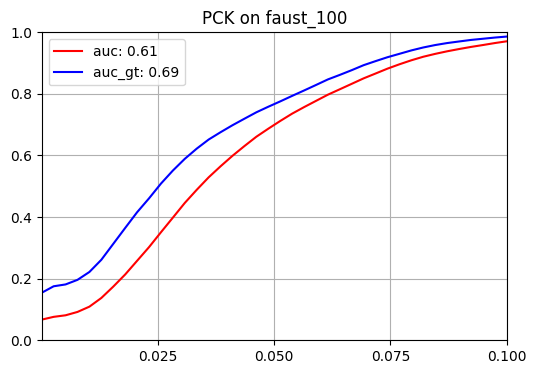

In [45]:
import sys
import os
curr_dir = os.getcwd()
if 's94zalek_hpc' in curr_dir:
    user_name = 's94zalek_hpc'
else:
    user_name = 's94zalek'
sys.path.append(f'/home/{user_name}/shape_matching')

# datasets
from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
from my_code.datasets.surreal_cached_test_dataset import SurrealTestDataset
import my_code.diffusion_training.sample_model as sample_model
import my_code.diffusion_training.evaluate_samples as evaluate_samples


# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import yaml
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



def get_subset(dataset, subset_fraction):
    
    # get n random samples
    n_samples = int(len(dataset) * subset_fraction)
    subset_indices = torch.randperm(len(dataset))[:n_samples]
    
    # return the subset
    return torch.utils.data.Subset(dataset, subset_indices), subset_indices


def plot_pck(metrics, metrics_gt, title):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    thresholds = np.linspace(0., 0.1, 40)
    ax.plot(thresholds, torch.mean(metrics['pcks'], axis=0), 'r-',
            label=f'auc: {torch.mean(metrics["auc"]):.2f}')
    ax.plot(thresholds, torch.mean(metrics_gt['pcks'], axis=0), 'b-',
            label=f'auc_gt: {torch.mean(metrics_gt["auc"]):.2f}')
    
    
    ax.set_xlim(0., 0.1)
    ax.set_ylim(0, 1)
    ax.set_xscale('linear')
    ax.set_xticks([0.025, 0.05, 0.075, 0.1])
    ax.grid()
    ax.legend()
    ax.set_title(title)
    return fig


def preprocess_metrics(metrics):
    metrics_payload = {}
    
    metrics_payload['auc'] = round(metrics['auc'].mean(dim=0).item(), 2)
    
    metrics_payload['geo_err_mean'] = round(metrics['geo_err_est'].mean().item() * 100, 1)
    metrics_payload['geo_err_median'] = round(metrics['geo_err_est'].median().item() * 100, 1)
    
    metrics_payload['geo_err_ratio_mean'] = round(metrics['geo_err_ratio'].mean().item(), 2)
    metrics_payload['geo_err_ratio_median'] = round(metrics['geo_err_ratio'].median().item(), 2)
    metrics_payload['geo_err_ratio_max'] = round(metrics['geo_err_ratio'].max().item(), 2)
    metrics_payload['geo_err_ratio_min'] = round(metrics['geo_err_ratio'].min().item(), 2)
    
    metrics_payload['mse_mean'] = round(metrics['mse_abs'].mean().item(), 2)
    metrics_payload['mse_median'] = round(metrics['mse_abs'].median().item(), 2)
    metrics_payload['mse_max'] = round(metrics['mse_abs'].max().item(), 2)
    metrics_payload['mse_min'] = round(metrics['mse_abs'].min().item(), 2)
    
    return metrics_payload



experiment_name = 'test_3DCoded_100_scaledFaust'
checkpoint_name = 'checkpoint_99'
subset_fraction = 100
dataset_name = 'faust'


### config
exp_base_folder = f'/home/{user_name}/shape_matching/my_code/experiments/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"]).to('cuda')
model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}.pt"))
model = model.to('cuda')


### dataset
# dataset_base_folder = '/home/s94zalek/shape_matching/data/SURREAL_full/full_datasets'
# test_dataset = SurrealTestDataset(f'{dataset_base_folder}/{config["dataset_name"]}/test')




import my_code.datasets.template_dataset as template_dataset
import datasets_code.shape_dataset as shape_dataset

dataset_faust_single_train = shape_dataset.SingleFaustDataset(
    data_root='data/FAUST_original',
    phase='train',
    return_faces=True,
    return_evecs=False, num_evecs=32,
    return_corr=True, return_dist=False
)

dataset_faust_single_test = shape_dataset.SingleFaustDataset(
    data_root='data/FAUST_original',
    phase='test',
    return_faces=True,
    return_evecs=False, num_evecs=32,
    return_corr=True, return_dist=False
)

test_dataset = template_dataset.TemplateDataset(
    base_dataset=dataset_faust_single_test,
    num_evecs=32,
    cache_lb_dir='/home/s94zalek_hpc/shape_matching/data/FAUST_scaled/original_32',
    return_Cxy=True
)

# print(test_dataset[10]['second']['C_gt_xy'].shape, test_dataset[10]['second']['evals'].shape, test_dataset[10]['first']['evals'].shape)
# exit(0)




subset_indices = list(range(len(test_dataset))) #[10:]

# return the subset
test_dataset = torch.utils.data.Subset(test_dataset, subset_indices)

# # optionally get a subset of the dataset
# if subset_fraction != 100:
#     test_dataset = get_subset(test_dataset, subset_fraction / 100)[0]

# dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset), shuffle=False
    )


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)
x_sampled = sample_model.sample(model, test_loader, noise_scheduler)    


### unnormalize the samples and assign gt signs
x_gt = torch.stack([test_dataset[i]['second']['C_gt_xy'] for i in range(len(test_dataset))])

fmap_sampled = []
for i in range(len(x_sampled)):
    fmap_i = x_sampled[i].cpu()

    fmap_i = (fmap_i + 1) / 2
    
    # set the sign to 0 for elements with absolute value < 0.05
    sign_gt_i = torch.sign(x_gt[i])
    sign_gt_i[torch.abs(x_gt[i]) < 0.05] = 0
    fmap_i = fmap_i * sign_gt_i
    
    # fmap_i = fmap_i * torch.sign(x_gt[i])


    fmap_sampled.append(fmap_i)
fmap_sampled = torch.stack(fmap_sampled)


### calculate metrics
metrics = evaluate_samples.calculate_metrics(
    fmap_sampled,
    test_dataset
)
metrics_gt = evaluate_samples.calculate_metrics(
    x_gt,
    test_dataset
)

metrics_payload = preprocess_metrics(metrics)
metrics_payload_gt = preprocess_metrics(metrics_gt)

fig = plot_pck(metrics, metrics_gt, title=f"PCK on {dataset_name}_{subset_fraction}")


### save the metrics and samples
# save_folder = f"{exp_base_folder}/evaluation"
# os.makedirs(save_folder, exist_ok=True)

# metrics
# with open(f"{save_folder}/metrics_{dataset_name}_{subset_fraction}.yaml", 'w') as f:
#     yaml.dump(metrics_payload, f, sort_keys=False)

# samples, fmaps, pck plot
# torch.save(x_sampled, f"{save_folder}/sampled_{dataset_name}_{subset_fraction}.pt")
# torch.save(fmap_sampled, f"{save_folder}/fmap_sampled_{dataset_name}_{subset_fraction}.pt")
# plt.savefig(f"{save_folder}/pck_{dataset_name}_{subset_fraction}.png")


### print the metrics
print(f"AUC mean: {metrics_payload['auc']}\n")
print(f'GeoErr mean: {metrics_payload["geo_err_mean"]}\n')
print(f'GeoErr median: {metrics_payload["geo_err_median"]}\n')

print(f"GeoErr ratio mean: {metrics_payload['geo_err_ratio_mean']}")
print(f"GeoErr ratio median: {metrics_payload['geo_err_ratio_median']}")
print(f'GeoErr ratio max: {metrics_payload["geo_err_ratio_max"]}', f'min: {metrics_payload["geo_err_ratio_min"]}\n')
print(f"MSE mean: {metrics_payload['mse_mean']}")
print(f"MSE median: {metrics_payload['mse_median']}")
print(f"MSE max: {metrics_payload['mse_max']}", f"min: {metrics_payload['mse_min']}")


print(f"\n\nAUC mean_gt: {metrics_payload_gt['auc']}\n")
print(f'GeoErr mean_gt: {metrics_payload_gt["geo_err_mean"]}\n')
print(f'GeoErr median_gt: {metrics_payload_gt["geo_err_median"]}\n')

print(f"GeoErr ratio mean_gt: {metrics_payload_gt['geo_err_ratio_mean']}")
print(f"GeoErr ratio median_gt: {metrics_payload_gt['geo_err_ratio_median']}")
print(f'GeoErr ratio max_gt: {metrics_payload_gt["geo_err_ratio_max"]}', f'min_gt: {metrics_payload_gt["geo_err_ratio_min"]}\n')
print(f"MSE mean_gt: {metrics_payload_gt['mse_mean']}")
print(f"MSE median_gt: {metrics_payload_gt['mse_median']}")
print(f"MSE max_gt: {metrics_payload_gt['mse_max']}", f"min_gt: {metrics_payload_gt['mse_min']}")

fig.show()

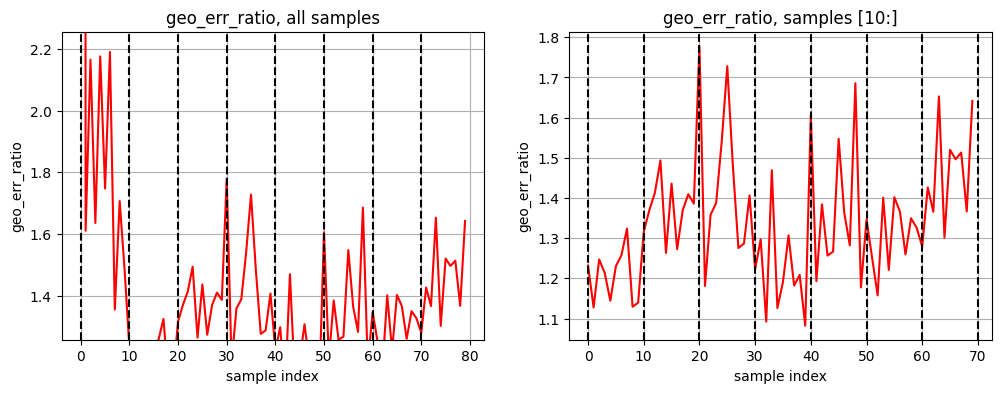

In [32]:
# plot metrics['geo_err_ratio']
# draw vertical lines every 10 samples

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(metrics['geo_err_ratio'].cpu().numpy(), 'r-')
ax[0].set_title('geo_err_ratio, all samples')
ax[0].set_ylabel('geo_err_ratio')
ax[0].set_xlabel('sample index')

# calculate mean and std
mean = metrics['geo_err_ratio'].mean().item()
std = metrics['geo_err_ratio'].std().item()
# scale axes
ax[0].set_ylim(mean - 0.5, mean + 0.5)
ax[0].grid()

ax[1].plot(metrics['geo_err_ratio'][10:].cpu().numpy(), 'r-')
ax[1].set_title('geo_err_ratio, samples [10:]')
ax[1].set_ylabel('geo_err_ratio')
ax[1].set_xlabel('sample index')
ax[1].grid()


for i in range(0, len(metrics['geo_err_ratio']), 10):
    ax[0].axvline(i, color='black', linestyle='--')
    ax[1].axvline(i, color='black', linestyle='--')
    
plt.show()

shape 0: 1.16
shape 1: 1.40
shape 2: nan
shape 3: nan
shape 4: nan
shape 5: nan
shape 6: nan
mean: nan

pose 0: 1.18
pose 1: 1.28
pose 2: 1.46
pose 3: 1.11
pose 4: 1.36
pose 5: 1.43
pose 6: 1.21
pose 7: 1.26
pose 8: 1.27
pose 9: 1.29
mean: 1.28


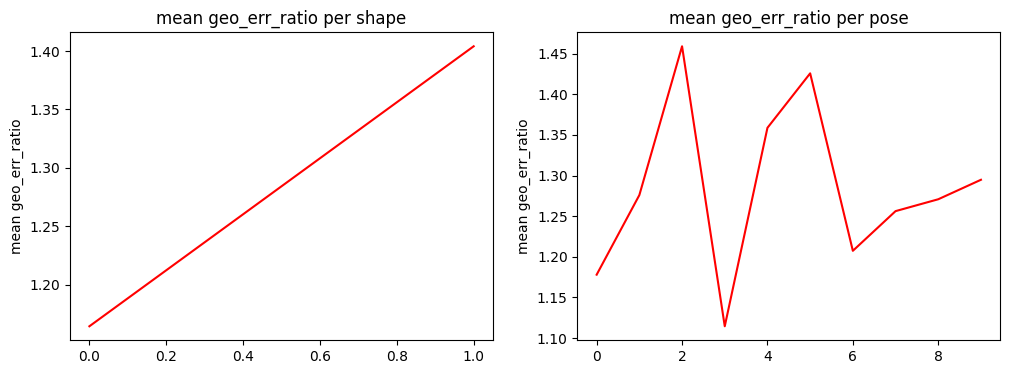

In [46]:
geo_err_ratio_no_1 = metrics['geo_err_ratio']


shape_ids = [i // 10 for i in range(len(geo_err_ratio_no_1))]
pose_ids = [i % 10 for i in range(len(geo_err_ratio_no_1))]

# for each shape and pose, print the mean geo_err_ratio

shape_ids = [i // 10 for i in range(len(geo_err_ratio_no_1))]
pose_ids = [i % 10 for i in range(len(geo_err_ratio_no_1))]
            
shape_ids = np.array(shape_ids)
pose_ids = np.array(pose_ids)

mean_geo_err_ratios_shape = []
for i in range(7):
    mean_geo_err_ratio = geo_err_ratio_no_1[shape_ids == i].mean().item()
    mean_geo_err_ratios_shape.append(mean_geo_err_ratio)
    print(f"shape {i}: {mean_geo_err_ratio:.2f}")
    
print(f"mean: {np.mean(mean_geo_err_ratios_shape):.2f}\n")

mean_geo_err_ratios_pose = []
for i in range(10):
    mean_geo_err_ratio = geo_err_ratio_no_1[pose_ids == i].mean().item()
    mean_geo_err_ratios_pose.append(mean_geo_err_ratio)
    print(f"pose {i}: {mean_geo_err_ratio:.2f}")
    
print(f"mean: {np.mean(mean_geo_err_ratios_pose):.2f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(mean_geo_err_ratios_shape, 'r-')
ax[0].set_title('mean geo_err_ratio per shape')
ax[0].set_ylabel('mean geo_err_ratio')

ax[1].plot(mean_geo_err_ratios_pose, 'r-')
ax[1].set_title('mean geo_err_ratio per pose')
ax[1].set_ylabel('mean geo_err_ratio')

plt.show()


In [14]:
import trimesh

scene = trimesh.Scene()

In [ ]:

scene.geometry.clear()


mesh_template = trimesh.Trimesh(vertices=test_dataset[0]['first']['verts'],
                                faces=test_dataset[0]['first']['faces'])

scene.add_geometry(mesh_template)

axis_scene = trimesh.creation.axis(origin_size=0.1)
scene.add_geometry(axis_scene)


for i in range(8):
    data_i = dataset_faust_single[i + 20]
    
    mesh_i = trimesh.Trimesh(vertices=data_i['verts'] + np.array([1 + i, 0, 0]), faces=data_i['faces'])
    
    scene.add_geometry(mesh_i)
    
scene.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for i in range(3):
    
    # sample_idx = np.random.randint(0, 10)#len(test_dataset))
    sample_idx = i + 0
    
    fmap_sampled = (x_sampled[sample_idx][0] + 1) / 2
    fmap_gt = x_gt[sample_idx][0]#.abs()
    
    ax_i = ax[i, 0].imshow(fmap_gt, cmap='bwr', vmin=-1, vmax=1)
    
    # ax_i = ax[i, 0].imshow(fmap_gt, cmap='Greys', vmin=0, vmax=1)
    plt.colorbar(ax_i, ax=ax[i, 0])
    ax[i, 0].set_title(f'GT {sample_idx}')
    
    ax_i = ax[i, 1].imshow(fmap_sampled, cmap='Greys', vmin=0, vmax=1)
    plt.colorbar(ax_i, ax=ax[i, 1])
    ax[i, 1].set_title(f'GeoErrRatio: {metrics["geo_err_ratio"][sample_idx]:.2f}')
    
    
    ax_i = ax[i, 2].imshow((fmap_sampled - fmap_gt.abs()).abs(), cmap='Greys', vmin=0, vmax=1)
    plt.colorbar(ax_i, ax=ax[i, 2])
    ax[i, 2].set_title(f'MSE: {metrics["mse_abs"][sample_idx]:.2f}')
    
    
    sign_gt_i = torch.sign(x_gt[sample_idx][0])
    sign_gt_i[torch.abs(x_gt[sample_idx][0]) < 0.05] = 0
    
    ax[i, 3].imshow(fmap_sampled * sign_gt_i, cmap='bwr', vmin=-1, vmax=1)
    ax[i, 3].set_title('sign of GT')
    
plt.show()

In [ ]:
metrics['p2p_gt'], metrics['p2p_est']

In [26]:
import trimesh

scene = trimesh.Scene()

In [ ]:
scene.geometry.clear()

# add light
scene.add_geometry(
    trimesh.scene.lighting.DirectionalLight(color=[255, 255, 255, 255],
                                            intensity=10)
    )

data_x = test_dataset[0]['first']
data_y = test_dataset[0]['second']

# cmap = trimesh.visual.color.interpolate(data_x['verts'][:, 1], 'jet')
# imterpolate the color diagonally based on 0 and 2 coordinate
cmap = trimesh.visual.color.interpolate(
    data_x['verts'][:, 0] / data_x['verts'][:, 0].max() +\
    data_x['verts'][:, 1] / data_x['verts'][:, 1].max(),
    'jet')
# make it brighter
# cmap = cmap * 1.5

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'], faces=data_x['faces'])
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)].clip(0, 255)
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=data_y['verts'] + np.array([1, 0, 0]), faces=data_y['faces'])
cmap2 = cmap[metrics['p2p_est'][0]]
mesh2.visual.vertex_colors = cmap2.clip(0, 255)
scene.add_geometry(mesh2)

scene.show()